# Concept activation vector

- Create function that gets values from specific hidden layer
- Find random samples
- Calculate concept activation vector
    - a) Using only single board position as the concept sample
    - b) Using often visited samples from the MCTS as the concept samples
- Create function that Calculates the TCAV

In [1]:
from utils import *

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
FORWARD_HOOK = True
BACKWARD_HOOK = True

model.eval()

if FORWARD_HOOK:
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    model.prediction.res_blocks.register_forward_hook(get_activation('res_blocks'))


    
if BACKWARD_HOOK:
    grad_dict = {}
    def get_grad(self, grad_input, grad_output):
        grad_dict['grad_input'] = grad_input
        grad_dict['grad_output'] = grad_output

    model.prediction.res_blocks.register_backward_hook(get_grad)

In [99]:
grid = np.array([[2, 0, 0, 2, 0],
                [2, 0, 2, 2, 2],
                [0, 2, 0, 1, 0],
                [0, 1, 1, 0, 0],
                [0, 1, 1, 1, 0],
                [1, 1, 1, 1, 1]])
player_to_move = 1

In [96]:
board = Board(5, grid)
state = State(board=board, player_to_move = player_to_move)
x = state.feature()
input = torch.from_numpy(x).unsqueeze(0)
p, v = model.prediction(input)
v.backward()

In [97]:
grad = grad_dict['grad_output'][0]
act_concept = activation['res_blocks']

In [60]:
# create random boards
import random 

N = 25
max_moves = 20

act_random = []
grad_random = []


for i in range(N):
    state = State()
    moves = random.randint(1, max_moves)
    for move in range(moves):
        random_action = random.choice(state.legal_actions())
        state.play(random_action)
        
    x = state.feature()
    input = torch.from_numpy(x).unsqueeze(0)
    p, v = model.prediction(input)
    v.backward()
    
    act_random.append(activation['res_blocks'].flatten())
    grad_random.append(grad_dict['grad_output'][0].flatten())
    


/home/ap/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [101]:
def get_tcav_from_state(state, cav):
    
    x = state.feature()
    input = torch.from_numpy(x).unsqueeze(0)
    p, v = model.prediction(input)
    v.backward()
    
    grad = grad_dict['grad_output'][0].flatten()
    
    g_numpy = grad.flatten().numpy()
    
    cav_norm = cav / np.linalg.norm(cav)
    
    g_norm = g_numpy / np.linalg.norm(g_numpy)
    dot_prod = np.dot(cav_norm, g_norm)
    return dot_prod

In [102]:
tcav = get_tcav_from_state(state, cav)
print(tcav)

0.08757837916997652


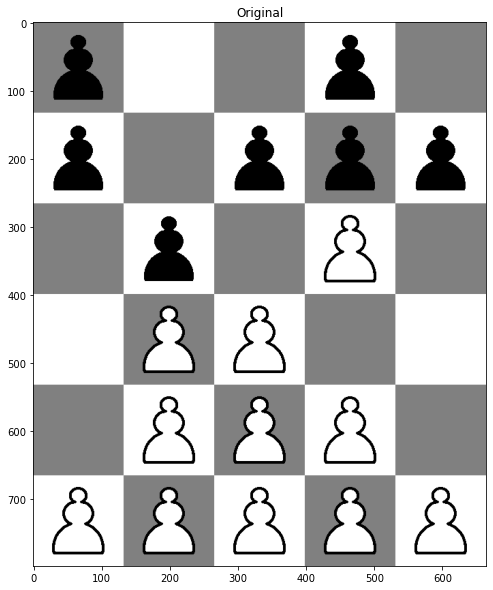

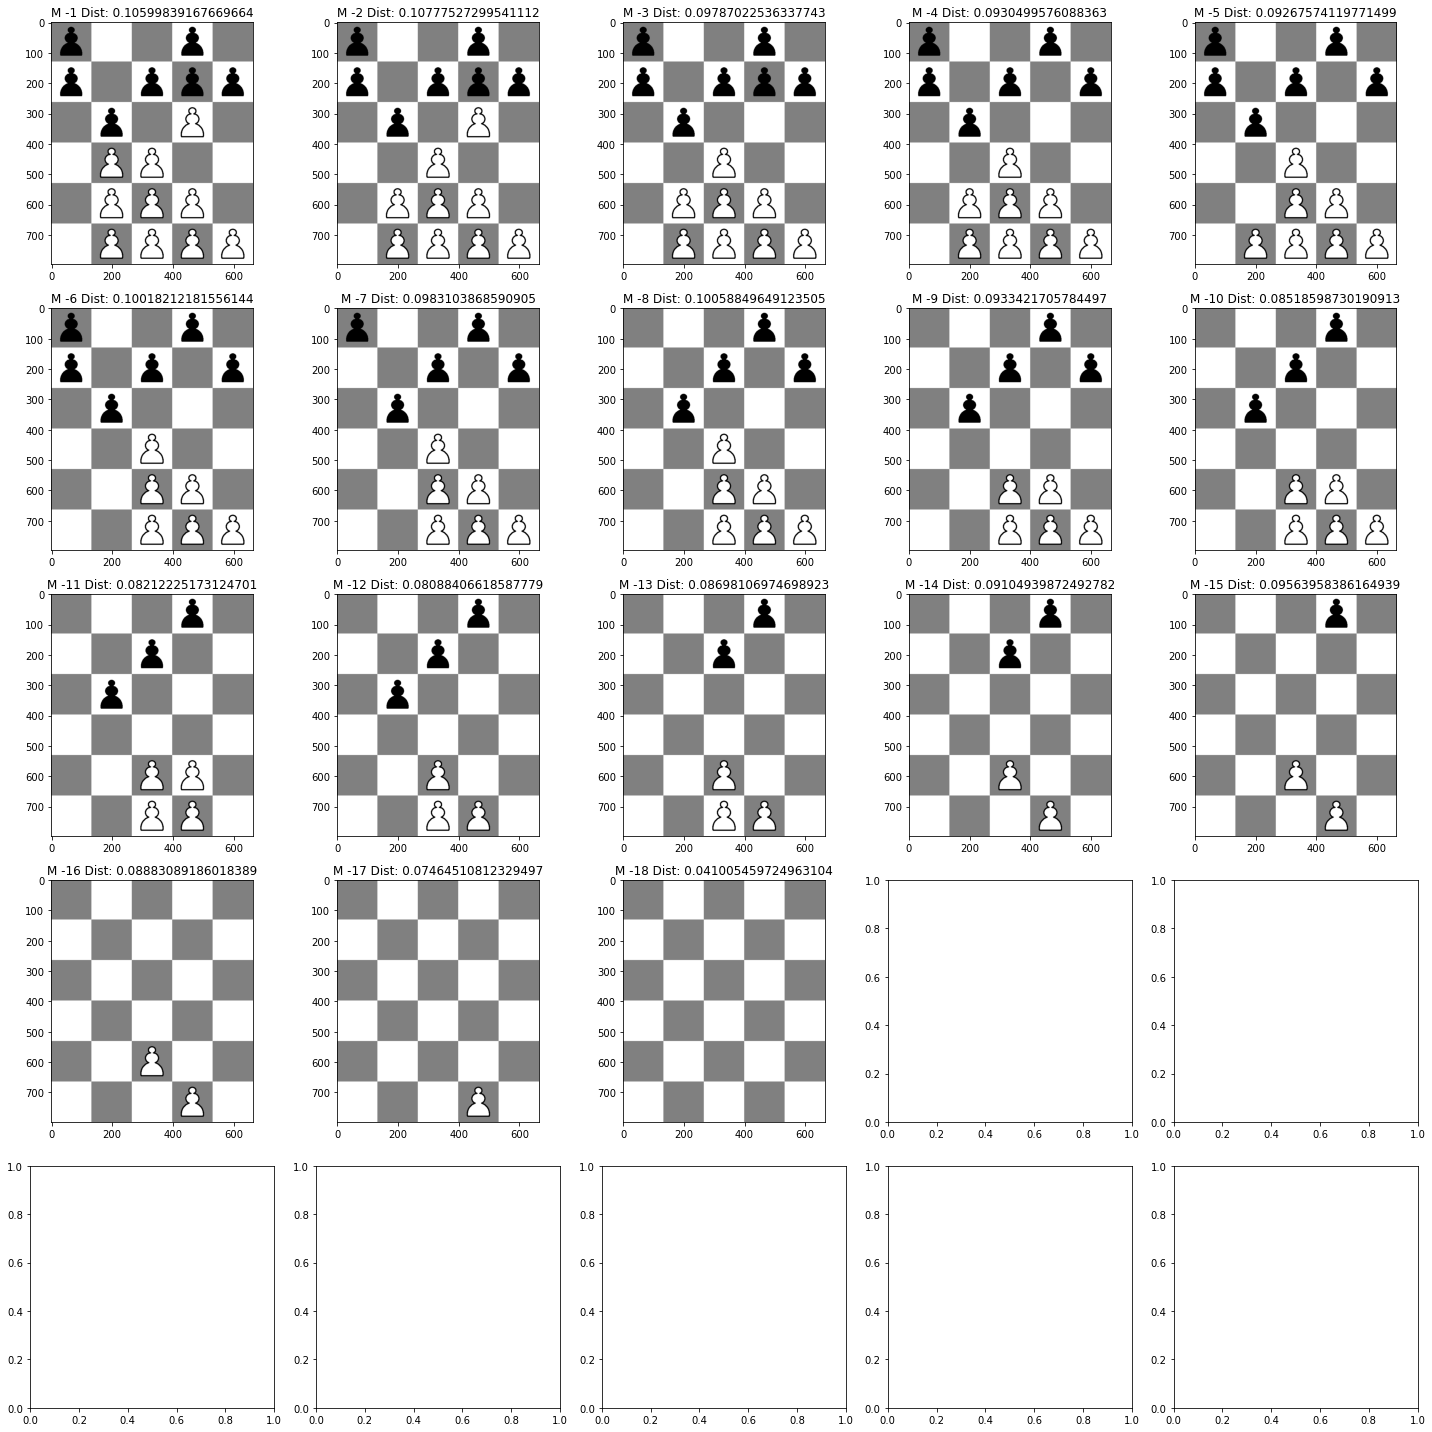

In [103]:
board = Board(5, grid)
state = State(board=board, player_to_move = player_to_move)
state_inter = copy.deepcopy(state)
x = state_inter.feature()
output = model.prediction.inference(x)
act_inter = activation['res_blocks']
plt.imshow(get_image_array(state))
plt.title('Original')
plt.show()

total_num = np.sum(state.board.grid != 0)
grid_size = int(np.ceil(np.sqrt(total_num)))

fig, axs = plt.subplots(grid_size, grid_size, figsize = (20,20))

for num in range(total_num):
    pieces_pos = np.where(state_inter.board.grid != 0)
    m = []
    for idx, (x,y) in enumerate(zip(pieces_pos[0],pieces_pos[1])):
        state_ = copy.deepcopy(state_inter)
        state_.board.grid[x,y] = 0
        tcav = get_tcav_from_state(state_, cav)
        
        
        m.append(tcav)
        
        
    max_sim = np.argmax(m)
    
    throw_idx = (pieces_pos[0][max_sim], pieces_pos[1][max_sim])    
    state_inter.board.grid[throw_idx[0], throw_idx[1]] = 0

    
    
    axs[num // grid_size, num % grid_size].imshow(get_image_array(state_inter))
    axs[num // grid_size, num % grid_size].title.set_text('M -'+str(num+1)+ ' Dist: '+str(m[max_sim]))
plt.tight_layout()
plt.show()

In [61]:
act_random

[tensor([ 2.2379,  4.6557,  3.5825,  ...,  0.0000, 14.0675, 10.8240]),
 tensor([0.6333, 0.0000, 2.2516,  ..., 0.0000, 1.1348, 0.0742]),
 tensor([3.2050, 3.1626, 4.2524,  ..., 4.8552, 0.9283, 4.0606]),
 tensor([3.7565, 4.7289, 5.2662,  ..., 0.4225, 0.0000, 1.7735]),
 tensor([3.8129, 4.5899, 6.2116,  ..., 0.0000, 0.0000, 0.0000]),
 tensor([2.8698, 4.1778, 3.2375,  ..., 0.0000, 0.0000, 0.0000]),
 tensor([4.5166, 3.9733, 3.9594,  ..., 0.0000, 0.0000, 0.5019]),
 tensor([2.4509, 5.3968, 2.9133,  ..., 0.0000, 0.0000, 0.0000]),
 tensor([4.1940, 4.5698, 4.6507,  ..., 1.8099, 0.3761, 0.0000]),
 tensor([5.1017, 6.8072, 4.0117,  ..., 0.0000, 0.0000, 0.0000]),
 tensor([1.6759, 7.6830, 6.4692,  ..., 0.8414, 0.0000, 0.0000]),
 tensor([0.6060, 2.8709, 4.6721,  ..., 6.9754, 4.0590, 2.8709]),
 tensor([ 4.9702,  5.4059, 11.7608,  ...,  0.0000,  0.0000,  0.0000]),
 tensor([0.7317, 3.6827, 3.3847,  ..., 1.2738, 0.0000, 0.0000]),
 tensor([3.6059, 3.5620, 3.9060,  ..., 0.0000, 0.0000, 0.0000]),
 tensor([5.33

In [62]:
from sklearn import linear_model
lm = linear_model.SGDClassifier(alpha=0.0001, tol=1e-3, max_iter=1000)

X = torch.stack([act_concept.flatten()] + act_random)
y = [1] + 25*[0]

In [63]:
lm.fit(X, y)

SGDClassifier()

In [81]:
cav = lm.coef_[0]
cav_norm = cav / np.linalg.norm(cav)

In [84]:
g_numpy = grad.flatten().numpy()
g_norm = g_numpy / np.linalg.norm(g_numpy)
dot_prod = np.dot(cav_norm, g_norm)
dot_prod

0.09877356514572977

In [94]:
g_numpy = grad.flatten().numpy()
g_norm = g_numpy / np.linalg.norm(g_numpy)
dot_prod = np.dot(cav_norm, g_norm)
dot_prod

0.09054718033587253

In [98]:
g_numpy = grad.flatten().numpy()
g_norm = g_numpy / np.linalg.norm(g_numpy)
dot_prod = np.dot(cav_norm, g_norm)
dot_prod

0.08757837916997652

In [85]:
v = []
for i in range(25):
    arr = grad_random[i].flatten().numpy()
    arr_norm = arr / np.linalg.norm(arr)
    
    dot_prod = np.dot(cav_norm, arr)
    v.append(dot_prod)

<ipython-input-85-ea98e23fcc60>:4: RuntimeWarning: invalid value encountered in true_divide
  arr_norm = arr / np.linalg.norm(arr)


In [86]:
v.sort()
v

[0.0,
 0.00047113150534134815,
 0.0005887844666715685,
 0.0007534518882206893,
 0.00116421213069008,
 0.0013897179188555667,
 0.0018321519542628746,
 0.001996729990553291,
 0.006290632116234728,
 0.00671484460905138,
 0.007500537368511629,
 0.009135729997146538,
 0.009685647330314823,
 0.012367022748880612,
 0.01497340326976423,
 0.015765116879410686,
 0.01601120808686449,
 0.016980846490586787,
 0.017190768754929933,
 0.024408169251015577,
 0.027098813041178026,
 0.03292283157222182,
 0.038967785371211504,
 0.04154537487442107,
 0.04259454613632279]

In [23]:
activation['res_blocks'].flatten()

tensor([3.7256, 1.9288, 3.0049,  ..., 0.0000, 0.0000, 0.0000])

In [5]:
board = Board(5, grid)
state = State(board=board, player_to_move = player_to_move)
x = state.feature()
input = torch.from_numpy(x).unsqueeze(0)
p, v = model.prediction(input)

/home/ap/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [8]:
v.backward()

In [9]:
grad_dict['grad_output'][0].shape

torch.Size([1, 64, 6, 5])

In [10]:
grad_dict = {}
def printgradnorm(self, grad_input, grad_output):
    grad_dict['grad_input'] = grad_input
    grad_dict['grad_output'] = grad_output


model.prediction.res_blocks.register_backward_hook(printgradnorm)

p,v = model.prediction(input)
err = 1-v
err.backward()

In [8]:
grad = grad_dict['grad_output'][0]
print(grad.shape)

torch.Size([1, 64, 6, 5])
